## CPOL and Berrima Dual Doppler test

Based on code created by Scott Collis, Johnathan Helmus, Zachary Sherman, and myself.<br />
Uses the OU DDA code to generate Dual Doppler Analysis.

In [51]:
import pyart
import gzip
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import rcParams
from scipy import ndimage
import shutil, os
from datetime import timedelta, datetime
import numpy as np
import tempfile
import glob
import re
import time
from copy import deepcopy
from IPython.display import Image, display
%matplotlib inline
import multidop
from mpl_toolkits import basemap
import math

In [52]:
## Input the range of dates and time wanted for the collection of images
start_year = 2010
start_day = 26
start_month = 3
start_hour = 10
start_minute = 0
start_second = 0

end_year = 2010
end_month = 3
end_day = 26
end_hour = 10
end_minute = 20
end_second = 0

data_path_cpol = '/home/rjackson/data/radar/cpol/'
data_path_berr = '/home/rjackson/data/radar/berr/'
data_path_cpol_cfradial = '/home/rjackson/data/radar/cpol/'
data_path_berr_cfradial = '/home/rjackson/data/radar/berr/'
sounding_file = '/home/rjackson/data/soundings/twpsondewnpnC3.b1.20020401.043300..20091230.172000.custom.cdf'

This looks for all of the available timeperiods in the data_path directory and pulls out
the file names that match the given time periods above.

In [53]:
# get_radar_times_cpol
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_radar_times_cpol(start_year, start_month, start_day,
                         start_hour, start_minute, end_year,
                         end_month, end_day, end_hour, 
                         end_minute, minute_interval=5):

    from datetime import timedelta, datetime
    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )  

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = range(0, no_days)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
 
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_cpol +
                      'Gunn_pt_' +
                      year_str +
                      month_str +
                      day_str +
                     '*.uf')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(data_path_cpol +
                             'Gunn_pt_' +
                              year_str +
                              month_str +
                              day_str +
                              '*.uf')
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-26:-12]
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[8:10]
        minute_str = date_str[10:12]
        second_str = date_str[12:14]
        
        
        
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
                   
    return time_list_final
# get_radar_times_cpol
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_radar_times_cpol_cfradial(start_year, start_month, start_day,
                                  start_hour, start_minute, end_year,
                                  end_month, end_day, end_hour, 
                                  end_minute, minute_interval=5):

    from datetime import timedelta, datetime
    from parse import parse
    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )  

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = range(0, no_days)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    
    # Find the list of files for each day
    cur_time = start_time
 
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        if(cur_time.year > 2006):
            format_str = (data_path_cpol_cfradial + 
                          '/' +
                          year_str + 
                          '/' +
                          year_str +
                          month_str +
                          day_str +
                          '/'
                          'cfrad.' +
                          year_str +
                          month_str +
                          day_str +
                          '*.nc')
        else:
            format_str = (data_path_cpol_cfradial + 
                          '/' +
                          year_str + 
                          '/' +
                          year_str +
                          month_str +
                          day_str +
                          '/'
                          'Gunn_Pt*' +
                          year_str +
                          month_str +
                          day_str +
                          '*.nc')
       
        print('Looking for files with format ' + format_str)      
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        if(cur_time.year > 2006):
            new_format_str = (data_path_cpol_cfradial +
                              '/' +
                              '{:d}' +
                              '/' +
                              '{:d}' +
                              '/' +
                              'cfrad.{:d}_{:d}.{:d}_to_{:d}_{:d}.{:d}_Gunn_Pt_v{:d}_UNKNOWN_SUR.nc')
            parameters = parse(new_format_str, file_name)
            year_str = np.floor(parameters[2]/10000)
            month_str = np.floor((parameters[2]-year_str*10000)/100)
            day_str = np.floor(parameters[2]-year_str*10000-month_str*100)
            hour_str = np.floor(parameters[3]/10000)
            minute_str = np.floor((parameters[3]-hour_str*10000)/100)
            second_str = np.floor(parameters[3]-hour_str*10000-minute_str*100)    
        else:
            date_str = file_name[-17:-3]
            year_str = date_str[0:4]
            month_str = date_str[4:6]
            day_str = date_str[6:8]
            hour_str = date_str[8:10]
            minute_str = date_str[10:12]
            day_str = date_str[12:14]
            
      
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
       
    for times in time_list_sorted:      
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
                   
    return time_list_final

# get_radar_times_cpol
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_radar_times_berr_cfradial(start_year, start_month, start_day,
                                  start_hour, start_minute, end_year,
                                  end_month, end_day, end_hour, 
                                  end_minute, minute_interval=5):

    from datetime import timedelta, datetime
    from parse import parse
    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )  

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = range(0, no_days)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    
    # Find the list of files for each day
    cur_time = start_time
 
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_berr_cfradial + 
                      '/' +
                      year_str + 
                      '/' +
                      year_str +
                      month_str +
                      day_str +
                      '/'
                      'cfrad.' +
                      year_str +
                      month_str +
                      day_str +
                      '*.nc')
       
        print('Looking for files with format ' + format_str)      
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        new_format_str = (data_path_berr_cfradial +
                         '/' +
                         '{:d}' +
                         '/' +
                         '{:d}' +
                         '/' +
                         'cfrad.{:d}_{:d}.{:d}_to_{:d}_{:d}.{:d}_Berrima_v{:d}_UNKNOWN_SUR.nc')
        parameters = parse(new_format_str, file_name)
        
        year_str = np.floor(parameters[2]/10000)
        month_str = np.floor((parameters[2]-year_str*10000)/100)
        day_str = np.floor(parameters[2]-year_str*10000-month_str*100)
        hour_str = np.floor(parameters[3]/10000)
        minute_str = np.floor((parameters[3]-hour_str*10000)/100)
        second_str = np.floor(parameters[3]-hour_str*10000-minute_str*100)   
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
       
    for times in time_list_sorted:      
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
                   
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_radar_from_cpol(time):
    from datetime import timedelta, datetime
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path_cpol +
                     'Gunn_pt_' +
                     year_str +
                     month_str +
                     day_str +
                     hour_str +
                     minute_str +
                     second_str +
                     '_PPI_deal.uf')
    radar = pyart.io.read_uf(file_name_str)
    return radar

# Get a Radar object given a time period in the CPOL dataset
def get_radar_from_cpol_cfradial(time):
    from datetime import timedelta, datetime
    import glob
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second

    file_name_str = (data_path_cpol_cfradial + 
                     '/' +
                     year_str + 
                     '/' +
                     year_str + 
                     month_str +
                     day_str +
                     '/' +  
                     'cfrad.' +
                     year_str +
                     month_str +
                     day_str +
                     '_' +
                     hour_str +
                     minute_str +
                     '*.nc')
    file_name = glob.glob(file_name_str)
    print(file_name_str)
    print(file_name)
    radar = pyart.io.read(file_name[0])
    return radar

# Get a Radar object given a time period in the CPOL dataset
def get_radar_from_berr_cfradial(time):
    from datetime import timedelta, datetime
    import glob
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second

    file_name_str = (data_path_berr_cfradial + 
                     '/' +
                     year_str + 
                     '/' +
                     year_str + 
                     month_str +
                     day_str +
                     '/' +  
                     'cfrad.' +
                     year_str +
                     month_str +
                     day_str +
                     '_' +
                     hour_str +
                     minute_str +
                     '*.nc')
    file_name = glob.glob(file_name_str)
    print(file_name_str)
    print(file_name)
    radar = pyart.io.read(file_name[0])
    return radar

Similar procedures as above, but getting times for the Berrima radar

In [54]:
# get_radar_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_radar_times_berr(start_year, start_month, start_day,
                        start_hour, start_minute, end_year,
                        end_month, end_day, end_hour, 
                        end_minute, minute_interval=5):

    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
    
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_berr +
                      'BerrimaVol' +
                      year_str +
                      month_str +
                      day_str +
                      '_deal.uf')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(data_path_berr +
                              'BerrimaVol' +
                              year_str +
                              month_str +
                              day_str +
                              '*deal.uf')
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-23:-8]
        
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[9:11]
        minute_str = date_str[11:13]
        second_str = date_str[13:15]
               
        
        
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
           
            
            
    
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_radar_from_berr(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path_berr +
                     'BerrimaVol' +
                     year_str +
                     month_str +
                     day_str +
                     '_' +
                     hour_str +
                     minute_str +
                     second_str +
                     '_deal.uf')
    print(file_name_str)    
    radar = pyart.io.read(file_name_str)
    return radar


In [55]:
# Plot the radars from given time.

times = get_radar_times_cpol_cfradial(start_year, start_month, start_day,
                                      start_hour, start_minute, end_year,
                                      end_month, end_day, end_hour, 
                                      end_minute, minute_interval=10)

times_berr = get_radar_times_berr_cfradial(start_year, start_month, start_day,
                                           start_hour, start_minute, end_year,
                                           end_month, end_day, end_hour, 
                                           end_minute, minute_interval=10)
print(times)
print(times_berr)

We are about to load grid files for 1 days
Looking for files with format /home/rjackson/data/radar/cpol//2010/20100326/cfrad.20100326*.nc
We are about to load grid files for 1 days
Looking for files with format /home/rjackson/data/radar/berr//2010/20100326/cfrad.20100326*.nc
[datetime.datetime(2010, 3, 26, 10, 10, 2)]
[datetime.datetime(2010, 3, 26, 10, 10, 2)]


This calculates the texture of the velocity field for both radars.

In [56]:
# Calculate texture of velocity field for Berrima and CPOL
frame_number = 0
Radar = get_radar_from_cpol_cfradial(times[frame_number])
frame_number = 0
Radar_berr = get_radar_from_berr_cfradial(times_berr[frame_number])
Radar_berr.info()

print('Calculating texture....')
nyq_Gunn = Radar.instrument_parameters['nyquist_velocity']['data'][0]
nyq_Berr = Radar_berr.instrument_parameters['nyquist_velocity']['data'][0]
data = ndimage.filters.generic_filter(Radar.fields['corrected_velocity']['data'],
                                      pyart.util.interval_std, size = (6,6),
                                      extra_arguments = (-nyq_Gunn, nyq_Gunn))
filtered_data = ndimage.filters.median_filter(data, size = (4,4))
texture_field = pyart.config.get_metadata('corrected_velocity')
texture_field['data'] = filtered_data

Radar.add_field('velocity_texture', texture_field, replace_existing = True)

data = ndimage.filters.generic_filter(Radar_berr.fields['corrected_velocity']['data'],
                                      pyart.util.interval_std, size = (6,6),
                                      extra_arguments = (-nyq_Gunn, nyq_Gunn))
filtered_data = ndimage.filters.median_filter(data, size = (4,4))
texture_field = pyart.config.get_metadata('corrected_velocity')
texture_field['data'] = filtered_data
Radar_berr.add_field('velocity_texture', texture_field, replace_existing = True)
print('Done!')
print(max(Radar_berr.instrument_parameters['nyquist_velocity']['data']))

/home/rjackson/data/radar/cpol//2010/20100326/cfrad.20100326_1010*.nc
['/home/rjackson/data/radar/cpol//2010/20100326/cfrad.20100326_101002.000_to_20100326_101746.000_Gunn_Pt_v12919_UNKNOWN_SUR.nc']
/home/rjackson/data/radar/berr//2010/20100326/cfrad.20100326_1010*.nc
['/home/rjackson/data/radar/berr//2010/20100326/cfrad.20100326_101002.000_to_20100326_101515.000_Berrima_v57_UNKNOWN_SUR.nc']
altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: altitude
	positive: up
	units: meters
	_FillValue: -9999.0
altitude_agl:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: altitude_above_ground_level
	positive: up
	units: meters
	_FillValue: -9999.0
antenna_transition:
	data: <ndarray of type: int8 and shape: (5400,)>
	long_name: antenna_is_in_transition_between_sweeps
	units: 
	_FillValue: -128
	comment: 1 if antenna is in transition, 0 otherwise
azimuth:
	data: <ndarray of type: float32 and shape: (5400,)>
	long_name: ray_azimuth_angle
	units: degrees
	_FillValu

This plots the reflectivity.

Loading scan closest to 10:10:02


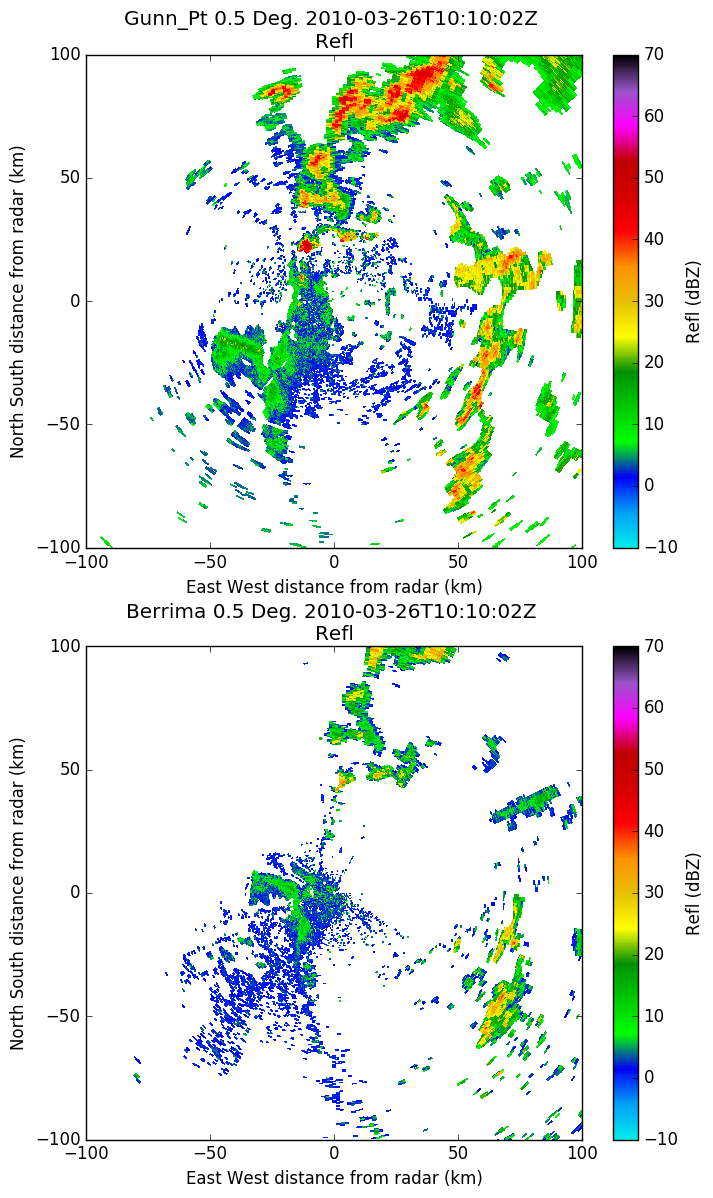

In [140]:
# This is the callback function for the animation.

fig1 = plt.figure(figsize=(8,14))
plt.subplot(211)

gatefilter_Gunn = pyart.correct.GateFilter(Radar)
gatefilter_Gunn.exclude_above('velocity_texture', 3)
gatefilter_Gunn.exclude_below('Refl',0)

gatefilter_Berr = pyart.correct.GateFilter(Radar_berr)
gatefilter_Berr.exclude_above('velocity_texture', 4)
gatefilter_Berr.exclude_below('Refl',0)

# Plot unfiltered reflectivity field
display = pyart.graph.RadarMapDisplay(Radar)
display.plot_ppi('Refl', sweep=0,
                 vmin=-10, vmax=70, cmap=pyart.graph.cm.NWSRef,
                 gatefilter=gatefilter_Gunn)
plt.xlim([-100,100])
plt.ylim([-100,100])

print("Loading scan closest to " + times[frame_number].strftime('%H:%M:%S'))

plt.subplot(212)
display = pyart.graph.RadarMapDisplay(Radar_berr)
display.plot_ppi('Refl', sweep=0,
                 vmin=-10, vmax=70, cmap=pyart.graph.cm.NWSRef,
                 gatefilter=gatefilter_Berr)
plt.xlim([-100,100])
plt.ylim([-100,100])
rcParams.update({'font.size': 12})  

Plot texture of velocity field for case to try and find proper threshold for filtering out noise from CPOL. Berrima is already corrected.

Loading scan closest to 10:10:02


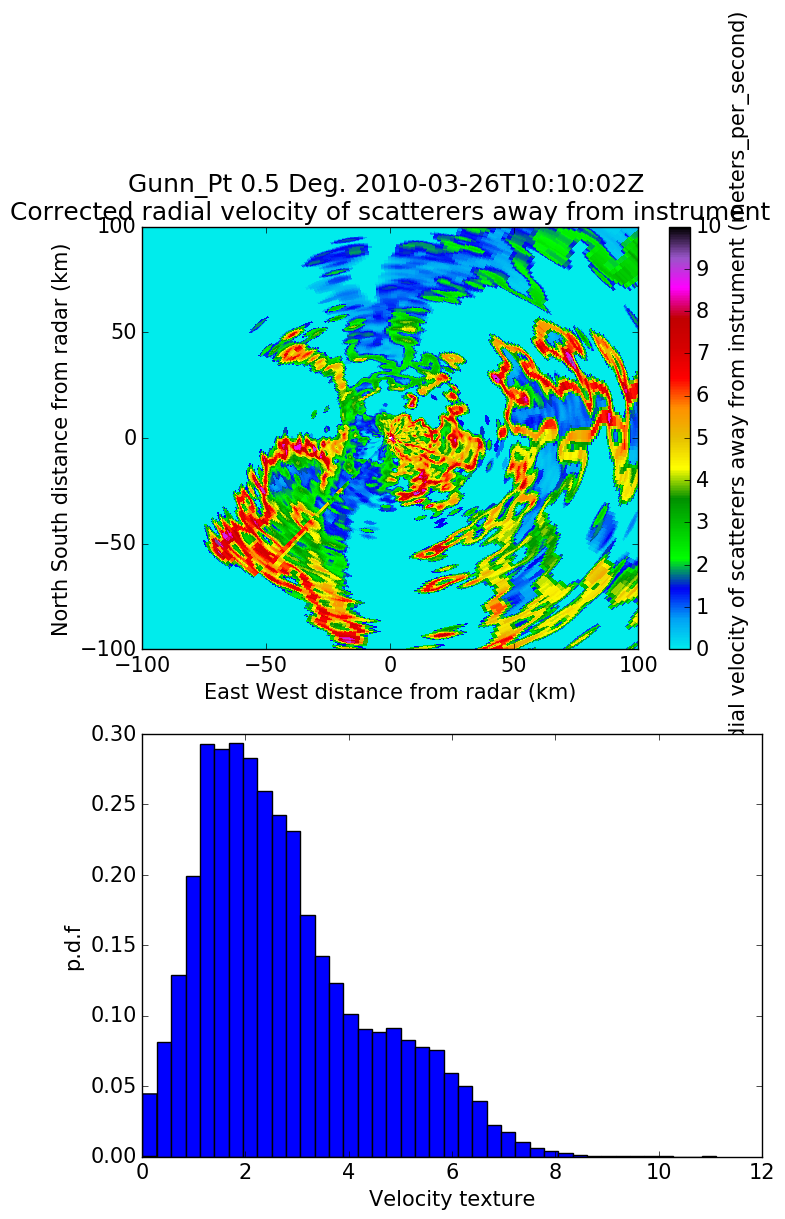

In [138]:
plt.clf()
print("Loading scan closest to " + times[frame_number].strftime('%H:%M:%S'))

fig1 = plt.figure(figsize=(8,12))
# Calculate texture of velocity field

plt.subplot(211)
display = pyart.graph.RadarMapDisplay(Radar)
display.plot_ppi('velocity_texture', sweep=0,
                 vmin=0, vmax=10, cmap=pyart.graph.cm.NWSRef)
plt.xlim([-100,100])
plt.ylim([-100,100])
rcParams.update({'font.size': 15})

plt.subplot(212)
texture = Radar_berr.fields['velocity_texture']['data']
plt.hist(texture[texture > 0], normed=1, bins=40)
plt.xlabel('Velocity texture')
plt.ylabel('p.d.f')

Plot velocity field. The velocity fields in the Berrima and Gunn files are already dealiased, so (hopefully) we do not need to worry too much about aliasing. However, it does look like some aliasing was not corrected for in the Berrima data.

Loading scan closest to 10:10:02


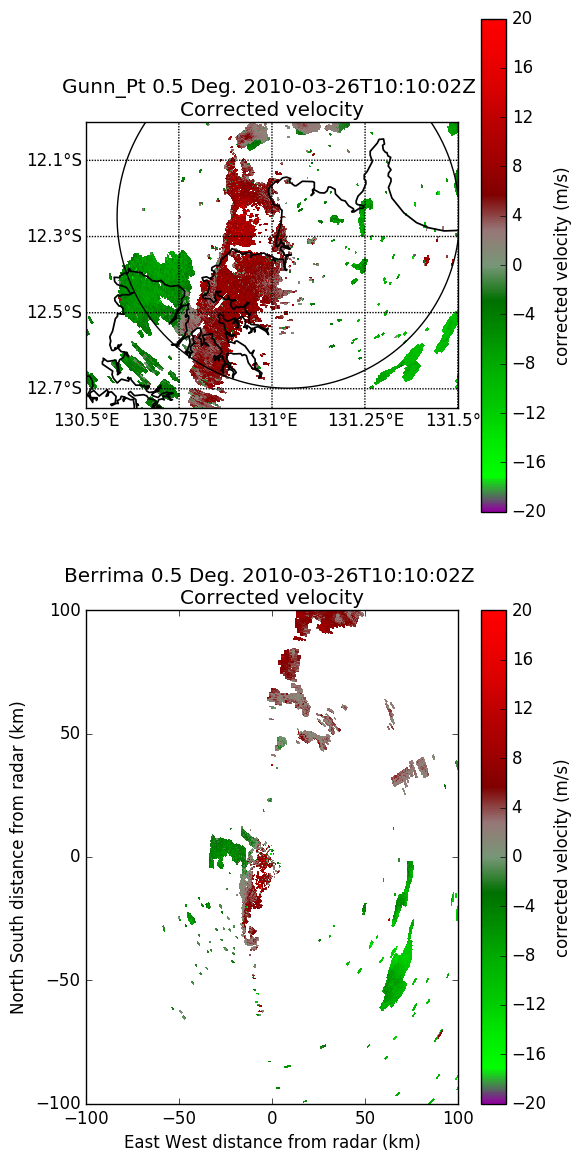

In [113]:
print("Loading scan closest to " + times[frame_number].strftime('%H:%M:%S'))

fig1 = plt.figure(figsize=(6,14))

plt.subplot(211)

# Calculate texture of velocity field
display = pyart.graph.RadarMapDisplay(Radar)
display.plot_ppi_map('corrected_velocity', sweep=0,
                     vmin=-20, vmax=20, cmap=pyart.graph.cm.NWSVel,
                     min_lat=-12.75, max_lat=-12,
                     min_lon=130.5, max_lon=131.5,
                     lat_lines=[-12.7, -12.5, -12.3, -12.1],
                     lon_lines=[130.5, 130.75, 131.0, 131.25, 131.5],
                     gatefilter=gatefilter_Gunn)
display.plot_range_ring(50,line_style='k')

#plt.xlim([-100,100])
#plt.ylim([-100,100])
rcParams.update({'font.size': 12}) 

plt.subplot(212)
display = pyart.graph.RadarMapDisplay(Radar_berr)
display.plot_ppi('corrected_velocity', sweep=0,
                 vmin=-20, vmax=20, cmap=pyart.graph.cm.NWSVel,
                 gatefilter=gatefilter_Berr)
                     
                    

plt.xlim([-100,100])
plt.ylim([-100,100])
rcParams.update({'font.size': 12}) 

We need to regrid the radar data into a Cartesian grid centered around the CPOL radar

In [132]:
def example_roi_func_dist_beam(zg, yg, xg):
    
    # RoI function parameters
    h_factor = 1.0      # height scaling
    nb = 1.5            # virtual beam width
    bsp = 1.0           # virtual beam spacing
    min_radius = 500.   # minimum radius in meters
    offsets = ((0, 0, 0), )  # z, y, x offset of grid in meters from radar(s)

    offsets = np.array(offsets)
    zg_off = offsets[:, 0]
    yg_off = offsets[:, 1]
    xg_off = offsets[:, 2]
    r = np.maximum(
            h_factor * ((zg - zg_off) / 20.0) +
            np.sqrt((yg - yg_off)**2 + (xg - xg_off)**2) *
            np.tan(nb * bsp * np.pi / 180.0), min_radius)
    return min(r)

#class RoiFunction inc_with_height:
    
#    min_radius = 500
#    max_radius = 2000
#    min_height = 0
#    max_height = 15000
#    slope = (max_radius-min_radius)/(max_height-min_height)
#    return slope*(zg - min_height) + min_radius

def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000), bsp=1.0, 
               min_radius=750, h_factor=4.0, nb=1.5,
               fields=['DT', 'VT'], origin=None, gatefilter=False):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        weighting_function='Barnes',
        gridding_algo='map_gates_to_grid',
        h_factor=h_factor,
        min_radius=min_radius,
        bsp=bsp,
        nb=nb, 
        gatefilters=[gatefilter])
    print(time.time() - bt, 'seconds to grid radar')
    return grid

In [133]:
# Change variable names to DT (reflectivity) and VT (velocity) expected by multidop
# If you needed to dealias or perform other corrections,
# this would be the time to start doing that.
# Both datasets already have aliasing corrections
cp = deepcopy(Radar.fields['Refl']['data'])
texture = Radar.fields['velocity_texture']['data']

# Apply texture filter to CPOL data
cp = np.ma.masked_where(texture > 3, cp)
Radar.add_field_like('Refl', 'DT', cp, replace_existing=True)
cp = deepcopy(Radar.fields['corrected_velocity']['data'])
cp = np.ma.masked_where(texture > 3, cp)
Radar.add_field_like('corrected_velocity', 'VT', cp, replace_existing=True)

cp = deepcopy(Radar_berr.fields['Refl']['data'])
texture = Radar_berr.fields['velocity_texture']['data']
cp = np.ma.masked_where(texture > 3, cp)
Radar_berr.add_field_like('Refl', 'DT', cp, replace_existing=True)
cp = deepcopy(Radar_berr.fields['corrected_velocity']['data'])
cp = np.ma.masked_where(texture > 3, cp)
Radar_berr.add_field_like('corrected_velocity', 'VT', cp, replace_existing=True)

# The analysis engine currently expects the "missing_value" attribute
Radar.fields['DT']['missing_value'] = 1.0 * Radar.fields['DT']['_FillValue']
Radar_berr.fields['DT']['missing_value'] = 1.0 * Radar_berr.fields['DT']['_FillValue']
Radar.fields['VT']['missing_value'] = 1.0 * Radar.fields['VT']['_FillValue']
Radar_berr.fields['VT']['missing_value'] = 1.0 * Radar_berr.fields['VT']['_FillValue']

# Grid the data to a Cartesian grid. The Dual doppler domain does not extend ~60 km 
# from both radars, so no need to store more data than that. 
grid_cpol = grid_radar(Radar, 
                       origin=(Radar.latitude['data'][0], Radar.longitude['data'][0]),
                       xlim=(-60000, 60000), ylim=(-60000, 60000), 
                       fields=['DT', 'VT'], min_radius=750.0, bsp=1.0, nb=1.5,
                       h_factor=2.0,
                       zlim=(500, 20000), grid_shape=(40, 121, 121),
                       gatefilter=gatefilter_Gunn)
grid_Berr = grid_radar(Radar_berr, 
                       origin=(Radar.latitude['data'][0], Radar.longitude['data'][0]),
                       fields=['DT', 'VT'],
                       xlim=(-60000, 60000), ylim=(-60000, 60000), 
                       zlim=(500, 20000), min_radius=750.0,  
                       grid_shape=(40, 121, 121),
                       bsp=1.0, nb=1.5, h_factor=2.0,
                       gatefilter=gatefilter_Berr)

# The analysis engine requires azimuth and elevation to be part of the grid.
# This information is computed from the grid geometry.
grid_cpol = multidop.angles.add_azimuth_as_field(grid_cpol)
grid_Berr = multidop.angles.add_azimuth_as_field(grid_Berr)
grid_cpol = multidop.angles.add_elevation_as_field(grid_cpol)
grid_Berr = multidop.angles.add_elevation_as_field(grid_Berr)

# Save the input grids for later.
pyart.io.write_grid('cpol_Darwin.nc', grid_cpol)
pyart.io.write_grid('berr_Darwin.nc', grid_Berr)

0.8920333385467529 seconds to grid radar
1.02384352684021 seconds to grid radar


/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/cfradial.py:786: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  ncvar[:] = data[:]


### Test grid output

{'units': 'm', 'data': array([   500.,   1000.,   1500.,   2000.,   2500.,   3000.,   3500.,
         4000.,   4500.,   5000.,   5500.,   6000.,   6500.,   7000.,
         7500.,   8000.,   8500.,   9000.,   9500.,  10000.,  10500.,
        11000.,  11500.,  12000.,  12500.,  13000.,  13500.,  14000.,
        14500.,  15000.,  15500.,  16000.,  16500.,  17000.,  17500.,
        18000.,  18500.,  19000.,  19500.,  20000.]), 'axis': 'Z', 'long_name': 'Z distance on the projection plane from the origin', 'positive': 'up', 'standard_name': 'projection_z_coordinate'}


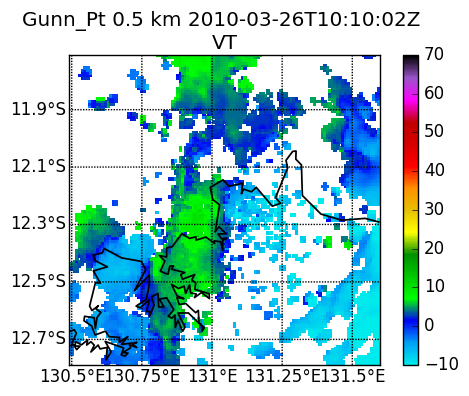

In [135]:
grid_cpol = pyart.io.read_grid('cpol_Darwin.nc')
CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_cpol)
CPOLGridDisplay.plot_basemap(min_lat=-13.0, max_lat=-11.8,
                             min_lon=130.3, max_lon=131.7,
                             lat_lines=[-12.7, -12.5, -12.3, -12.1, -11.9],
                             lon_lines=[130.5, 130.75, 131.0, 131.25, 131.5],
                             resolution='i')
CPOLGridDisplay.plot_grid('VT', 0, vmin=-10, vmax=70,
                          cmap=pyart.graph.cm.NWSRef)
print(grid_cpol.z)

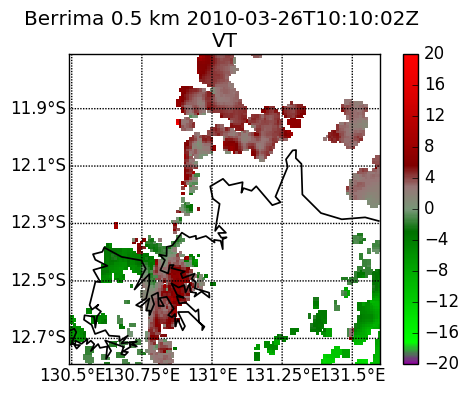

In [137]:
grid_Berr = pyart.io.read_grid('berr_Darwin.nc')
CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_Berr)
CPOLGridDisplay.plot_basemap(min_lat=-12.75, max_lat=-12,
                             min_lon=130.5, max_lon=131.5,
                             lat_lines=[-12.7, -12.5, -12.3, -12.1, -11.9],
                             lon_lines=[130.5, 130.75, 131.0, 131.25, 131.5],
                             resolution='i')
CPOLGridDisplay.plot_grid('VT', 0, vmin=-20, vmax=20,
                          cmap=pyart.graph.cm.NWSVel)

CPOL Vertical cross sections....right now these grids have more discontinuties and
data gaps compared to paper.

(-30, 60)

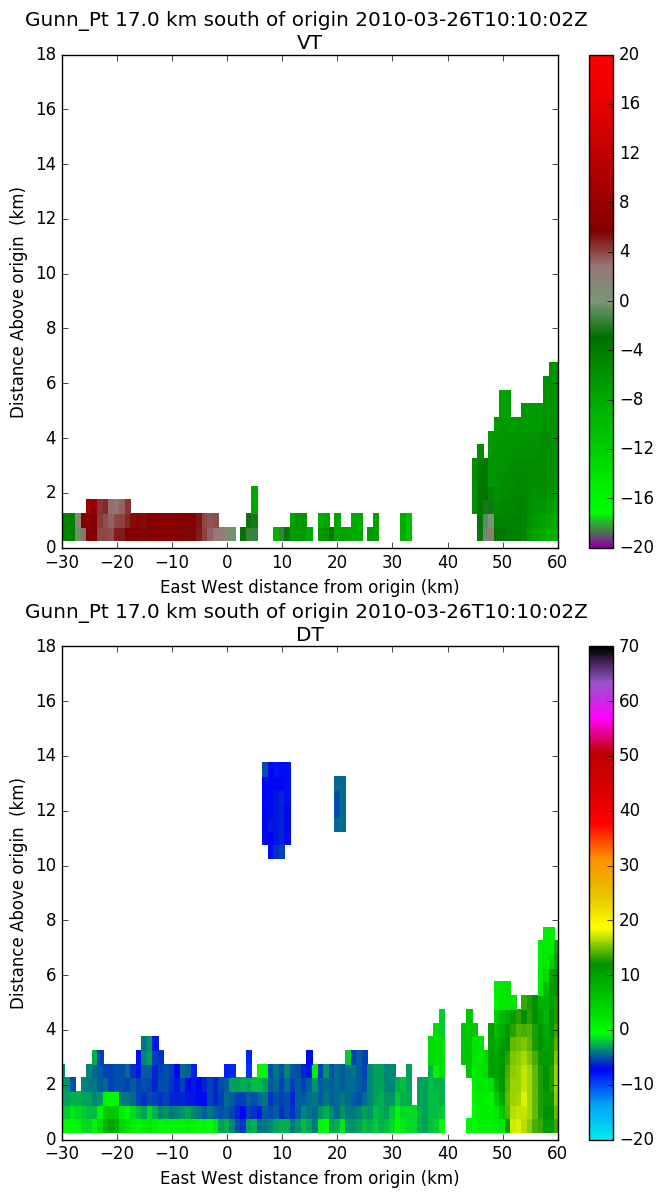

In [64]:
plt.figure(figsize=(8,14))
plt.subplot(211)
CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_cpol)
CPOLGridDisplay.plot_latitude_slice('VT', lat=-12.4, lon=130.5,
                                    cmap=pyart.graph.cm.NWSVel,
                                    vmin=-20, vmax=20)                           
                                    
plt.xlim([-30, 60])

plt.subplot(212)
CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_cpol)
CPOLGridDisplay.plot_latitude_slice('DT', lat=-12.4, lon=130.5,
                                    cmap=pyart.graph.cm.NWSRef,
                                    vmin=-20, vmax=70)                           
                                    
plt.xlim([-30, 60])

Berrima Vertical cross section....right now these grids have more discontinuties and
data gaps compared to paper.

(-30, 60)

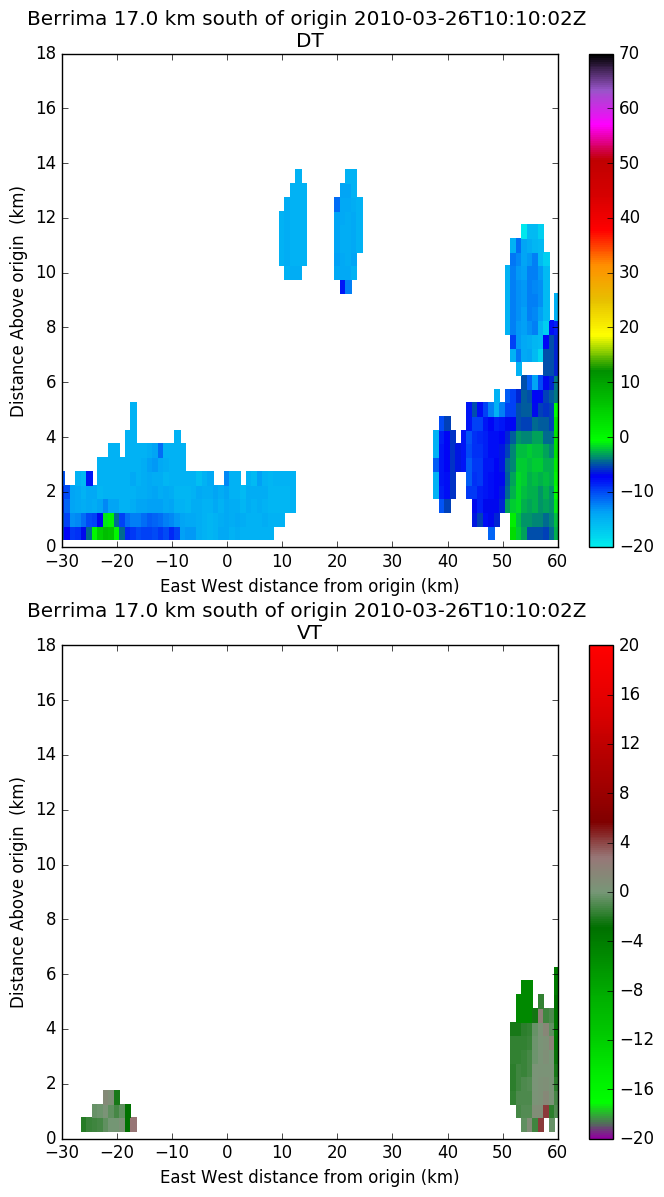

In [65]:
plt.figure(figsize=(8,14))
plt.subplot(211)
CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_Berr)
CPOLGridDisplay.plot_latitude_slice('DT', lat=-12.4, lon=130.5,
                                    cmap=pyart.graph.cm.NWSRef,
                                    vmin=-20, vmax=70)                           
                                    
plt.xlim([-30, 60])

plt.subplot(212)
CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_Berr)
CPOLGridDisplay.plot_latitude_slice('VT', lat=-12.4, lon=130.5,
                                    cmap=pyart.graph.cm.NWSVel,
                                    vmin=-20, vmax=20)                           
plt.xlim([-30, 60])

Calculation for storm motion. Requires grid from previous timestep as well as grid from current timestep.

In [66]:
# Load radar from previous timestep
frame_number_previous = frame_number-1
Radar_prev = get_radar_from_cpol_cfradial(times[frame_number_previous])

print('Calculating texture....')
nyq_Gunn = Radar_prev.instrument_parameters['nyquist_velocity']['data'][0]
data = ndimage.filters.generic_filter(Radar_prev.fields['velocity']['data'],
                                      pyart.util.interval_std, size = (4,4),
                                      extra_arguments = (-nyq_Gunn, nyq_Gunn))
filtered_data = ndimage.filters.median_filter(data, size = (4,4))
texture_field = pyart.config.get_metadata('velocity')
texture_field['data'] = filtered_data

print('Gridding previous frame...')
cp = deepcopy(Radar_prev.fields['corrected_reflectivity']['data'])
cp = np.ma.masked_where(texture_field['data'] > 2, cp)
Radar_prev.add_field_like('corrected_reflectivity', 'DT', cp, replace_existing=True)
grid_prev = grid_radar(Radar_prev, 
                       origin=(Radar_prev.latitude['data'][0], Radar_prev.longitude['data'][0]),
                       xlim=(-60000, 60000), ylim=(-60000, 60000), 
                       fields=['DT'],
                       zlim=(1000, 20000), grid_shape=(39, 121, 121))
(v,u) = pyart.retrieve.grid_displacement_pc(grid_prev, grid_cpol, 'DT', 9, return_value='velocity')

print(('U = ' + str(u) + ' V = ' + str(v)))

fig=plt.figure(figsize=(6,14))
plt.subplot(211)

CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_cpol)
CPOLGridDisplay.plot_basemap(min_lat=-12.75, max_lat=-12,
                             min_lon=130.5, max_lon=131.5,
                             lat_lines=[-12.7, -12.5, -12.3, -12.1, -11.9],
                             lon_lines=[130.5, 130.75, 131.0, 131.25, 131.5],
                             resolution='i')
CPOLGridDisplay.plot_grid('DT', 0, vmin=-10, vmax=70,
                          cmap=pyart.graph.cm.NWSRef)
plt.subplot(212)
CPOLGridDisplay = pyart.graph.GridMapDisplay(grid_prev)
CPOLGridDisplay.plot_basemap(min_lat=-12.75, max_lat=-12,
                             min_lon=130.5, max_lon=131.5,
                             lat_lines=[-12.7, -12.5, -12.3, -12.1, -11.9],
                             lon_lines=[130.5, 130.75, 131.0, 131.25, 131.5],
                             resolution='i')
CPOLGridDisplay.plot_grid('DT', 0, vmin=-10, vmax=70,
                          cmap=pyart.graph.cm.NWSRef)

FileNotFoundError: [Errno 2] No such file or directory: '/home/rjackson/data/radar/cpol/Gunn_pt_20100326101002_PPI_deal.uf'

In [101]:
# You don't have to define everything. Most of these keywords are default values.
# If you don't define something the program will provide a default value.
# Check parameters.py for what keyword default values are.
localfile = tempfile.NamedTemporaryFile()
pd = {'dir': './',
      'x': [-60000.0, 1000.0, 111],   # start, step, max = min + (steps-1)
      'y': [-50000.0, 1000.0, 81],
      'z': [500.0, 500.0,  40],
      'grid': [grid_cpol.origin_longitude['data'][0], grid_cpol.origin_latitude['data'][0], 50.0],
      'files': ['berr_Darwin.nc',
                'cpol_Darwin.nc'],
      'radar_names': ['Berrima', 'CPOL'],
      'refl': 'DT',  # Name of reflectivity field. Must be common between radars.
      'vt': 'VT',  # Name of velocity field. Must be common between radars.
      'bgfile': 'sounding_file', # Name of sounding file
      'writeout': localfile.name, # Name of output grid file
      'min_cba': 30.0,  # Minimum beam-crossing angle
      'calc_params': 'cpol_calc.dda', # .dda file for parameters related to minimization routine
      'anel': 1, # 0 = Boussinesq approximation for mass conservation, 1 = anelastic 
      'laplace': 0, # 0 = 1st order derivatives for smoothing, 1 = second
      'read_dataweights': 2, # 0 = calculate data constraint weights/output, 1 = read from file, 2 = weigh all equally
      'max_dist': 10.0, # How much distance analysis and observational grid must match in m
      'cutoff': 0.0, # Deny observations below this level from analysis (m)
      'UT': 0.0, # U of prescribed storm motion vector
      'VT': -2.5, # V of prescribed storm motion vector
      'output_error': 0, # 1 = output verification stats after each iteration
      'weak_height': -1, # Sounding height constraint weakened in regions > 10 dBZ below this height (-1 = disabled)
      'upper_bc': 1, # 1 = w = 0 as upper boundary condition, -1 = ignore
      'itmax_frprmn': [200, 10], # max iterations in frprmn function
      'itmax_dbrent': 200, # max iterations in dbrent function
      'C1b': 1.0,  # Data weighting factor
      'C2b': 1500.0,  # Mass continuity weighting factor
      'C3b': 0.0,  # Vorticity weighting factor
      'C4b': 75.0,  # Horizontal smoothing factor
      'C5b': 0.0,  # Vertical smoothing factor
      'C8b': 0.0,  # Sounding factor
      'vary_weights': 0,
      # Define filter with ONE of the following forms.
      # filter: none
      # filter: filter_frequency Leise nstep
      # filter: filter_frequency low-pass alpha
      'filter': ['60', 'Leise', '2'],
      # Coverage values for various combinations of radars.
      # Each line should provide the type of coverage value, radar count,
      # radar names, and the value, in the following form:
      #
      #   cvg_(""|opt|sub)_(bg|fil): integer radar1 radar2 ... boolean
      #
      # Radars are identified by the OPAWS/OBAN file name with grid data for that
      # radar. This must be just the base name, not the full path.
      #
      # For example:
      #
      #   cvg_opt_bg: SR1 SR2 1
      #
      # says that if SR1 SR2
      # both have data within max_dist meters of the point under consideration,
      # and an optimal beam crossing angle, then the point will receive a coverage
      # value of 1, i.e. point has coverage.
      #
      # "opt" means optimal beam crossing angle.
      # "sub" means suboptimal beam crossing angle.
      # "bg" means background coverage.
      # "fil" means filter coverage.
      # cvg_bg, cvg_fil, and sseq_trip do not require a radar count. (Beam crossing
      # angle is meaningless with one radar, so there is no opt or sub)
      #
      # If this file is being used, coverage values must be provided for all
      # combinations of radars.
      'cvg_opt_bg': [1, 1, 0],
      'cvg_sub_bg': [1, 1, 0],
      'cvg_opt_fil': [0, 0, 0],
      'cvg_sub_fil': [1, 1, 0],
      'cvg_bg': [1, 1, 0],
      'cvg_fil': [0, 0, 0],
      'sseq_trip': [1.0, 1.0, 0.0]
     }
pf = multidop.parameters.ParamFile(pd, 'cpol_test.dda')
pf = multidop.parameters.CalcParamFile(pd, 'cpol_calc.dda')

In [102]:
# Unfortunately, text output from the analysis engine (DDA) will not display
# until after the program completes. Expect this step to take several minutes.
bt = time.time()
multidop.execute.do_analysis('cpol_test.dda', cmd_path='/home/rjackson/multidop/src/DDA')
print((time.time()-bt)/60.0, 'minutes to process')

DDA 0.8.2
./DDA: reading calculation parameters from cpol_calc.dda.
Changing working directory to ./
x: -60000.000000 to 50000.000000 in 110 steps of 1000.000000
y: -50000.000000 to 30000.000000 in 80 steps of 1000.000000
z: 500.000000 to 20000.000000 in 39 steps of 500.000000
z_min=500, cutoff=0
UT=0, VT=-2.5
Anelastic mass cons
First-order smoothness constraint
Minimum beam crossing angle = 30 degrees
Py-ART grids for analyis and all radars must match to within (dx, dy, dz) < (10 10 10) meters.
Reading Py-ART fileberr_Darwin.nc
cpol_Darwin.nc

Radar positions:  (-12912.7,-23115.8) (-0.333177,0.0452394)
Computing coverage: 12274 verification points out of 359640 total points.
radar0 14834 obs. radar1 33324 obs. 48158 total obs.
Analyzed obs = 48158. Mean Vr = 4.846
C1b=1 C2b=1500 C3b=0 C4b=75 C5b=0 C6b=0 C7b=75 C8b=0
C2a=1500 C3a=0 C4a=75 C5a=0 C6a=0 C7a=75 C8a=0
Weighting all obs equally!
GradCheck: rchek = 1e+10. fx1 = 3547.25
GradCheck: gxnn = 883.666
GradCheck: j = 1. fx2 = 6.339e

In [103]:
# Baseline output is not CF or Py-ART compliant. This function fixes that.
# This is why we wrote the original output to a tempfile that can be safely removed.
# The final grid will have all wind solutions outside the coverage region masked.
fname = 'cf_compliant_grid.nc'
final_grid = multidop.grid_io.make_new_grid([grid_cpol, grid_Berr], 
                                            localfile.name,
                                            use_mask=False)
final_grid.write(fname)
localfile.close()

In [104]:
pyart_grid = pyart.io.read_grid(fname)
print(pyart_grid.fields.keys())

dict_keys(['reflectivity', 'upward_air_velocity', 'eastward_wind', 'northward_wind'])


## Display merged reflectivities

In [71]:
def get_bca(grid):
    berr_origin = [-12960.1,-23091.1]
    x,y = np.meshgrid(grid.x['data'], grid.y['data'])
    a = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
    b = np.sqrt(pow(x-berr_origin[0],2)+pow(y-berr_origin[1],2))
    c = np.sqrt(berr_origin[0]*berr_origin[0]+berr_origin[1]*berr_origin[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-berr_origin[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

/home/rjackson/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3542: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


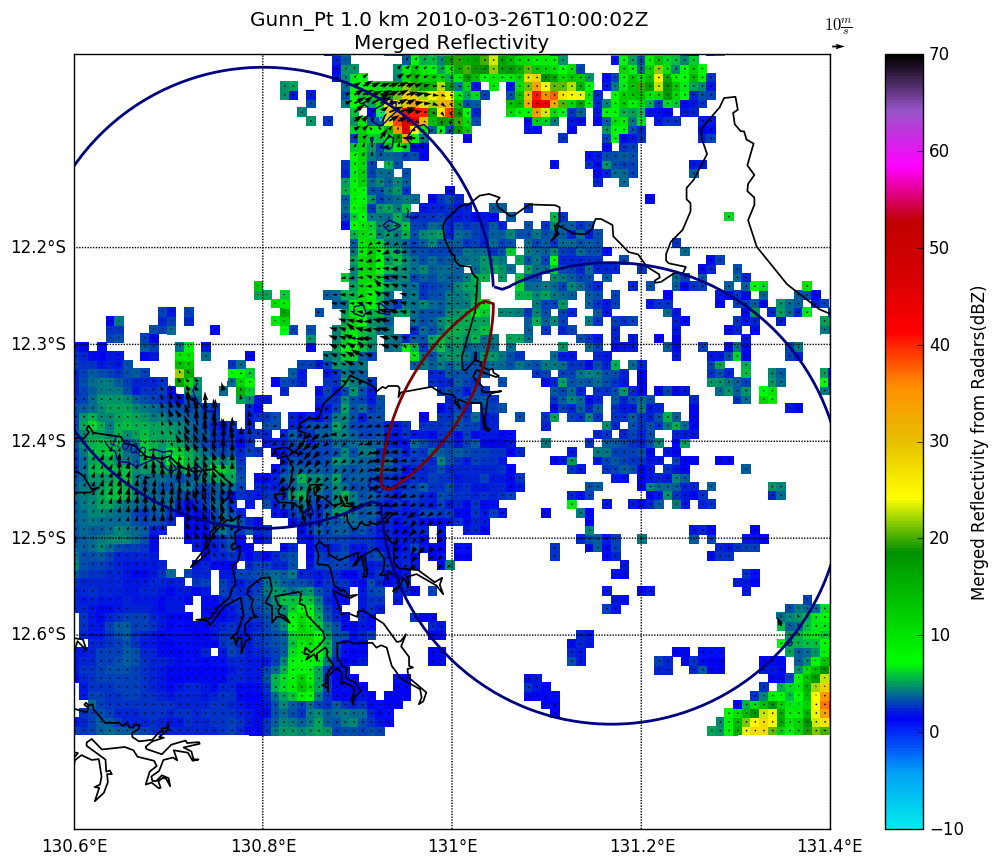

In [141]:
level = 1
fig1 = plt.figure(figsize=(14,10))
CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid)
CPOLGridDisplay.plot_basemap(min_lat=-12.8, max_lat=-12.0,
                             min_lon=130.6, max_lon=131.4,
                             auto_range=False,
                             lat_lines=[-12.6, -12.5, -12.4, -12.3, -12.2, -12.0],
                             lon_lines=[130.6, 130.8, 131.0, 131.2, 131.4],
                             resolution='h')
CPOLGridDisplay.plot_grid('reflectivity', level, vmin=-10, vmax=70,
                          cmap=pyart.graph.cm.NWSRef)

lons, lats = pyart_grid.get_point_longitude_latitude(level=level)
v = pyart_grid.fields['northward_wind']['data'][level]
u = pyart_grid.fields['eastward_wind']['data'][level]
w = pyart_grid.fields['upward_air_velocity']['data'][level]
Wcomp = np.amax(pyart_grid.fields['upward_air_velocity']['data'], axis=0)

q = CPOLGridDisplay.basemap.quiver(lons, lats, 
                                   u, v, 
                                   scale=600,
                                   latlon='True')
qk = plt.quiverkey(q, 1.01, 1.01, 10, r'$10  \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
CS = CPOLGridDisplay.basemap.contour(lons, lats,
                                     w, latlon='True',
                                     levels=[1, 4, 6, 10])
plt.clabel(CS, inline=1, fontsize=10)
bca = get_bca(pyart_grid)

CSa = CPOLGridDisplay.basemap.contour(lons, lats,
                                      bca, latlon='True',
                                      levels=[math.pi/6, 5*math.pi/6],
                                      linewidths=2)

/home/rjackson/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3542: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


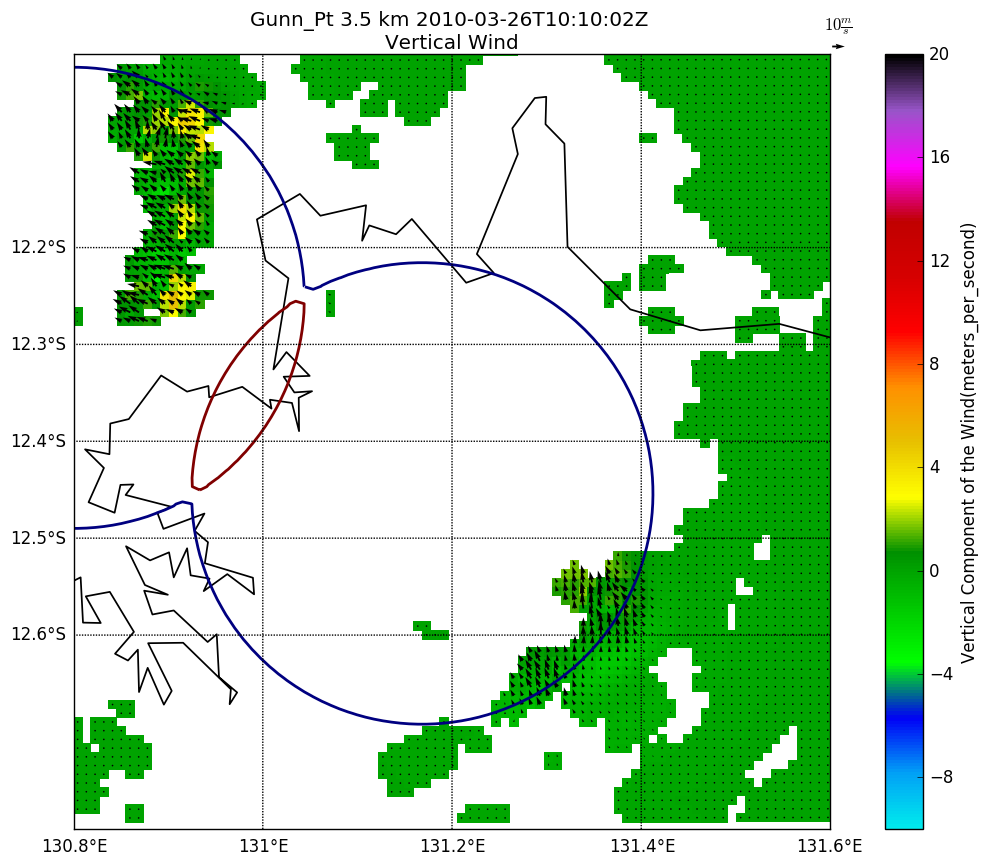

In [73]:
level = 6
fig1 = plt.figure(figsize=(14,10))
CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid)
CPOLGridDisplay.plot_basemap(min_lat=-12.8, max_lat=-12.0,
                             min_lon=130.8, max_lon=131.6,
                             auto_range=False,
                             lat_lines=[-12.6, -12.5, -12.4, -12.3, -12.2, -12,1, -12.0],
                             lon_lines=[130.8, 131.0, 131.2, 131.4, 131.6],
                             resolution='i')
CPOLGridDisplay.plot_grid('upward_air_velocity', level, vmin=-10, vmax=20,
                          cmap=pyart.graph.cm.NWSRef)

lons, lats = pyart_grid.get_point_longitude_latitude(level=level)
v = pyart_grid.fields['northward_wind']['data'][level]
u = pyart_grid.fields['eastward_wind']['data'][level]

q = CPOLGridDisplay.basemap.quiver(lons, lats, 
                                   u, v, 
                                   scale=600,
                                   latlon='True')
qk = plt.quiverkey(q, 1.01, 1.01, 10, r'$10  \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})

bca = get_bca(pyart_grid)
CSa = CPOLGridDisplay.basemap.contour(lons, lats,
                                      bca, latlon='True',
                                      levels=[math.pi/6, 5*math.pi/6],
                                      linewidths=2)

(-30, 40)

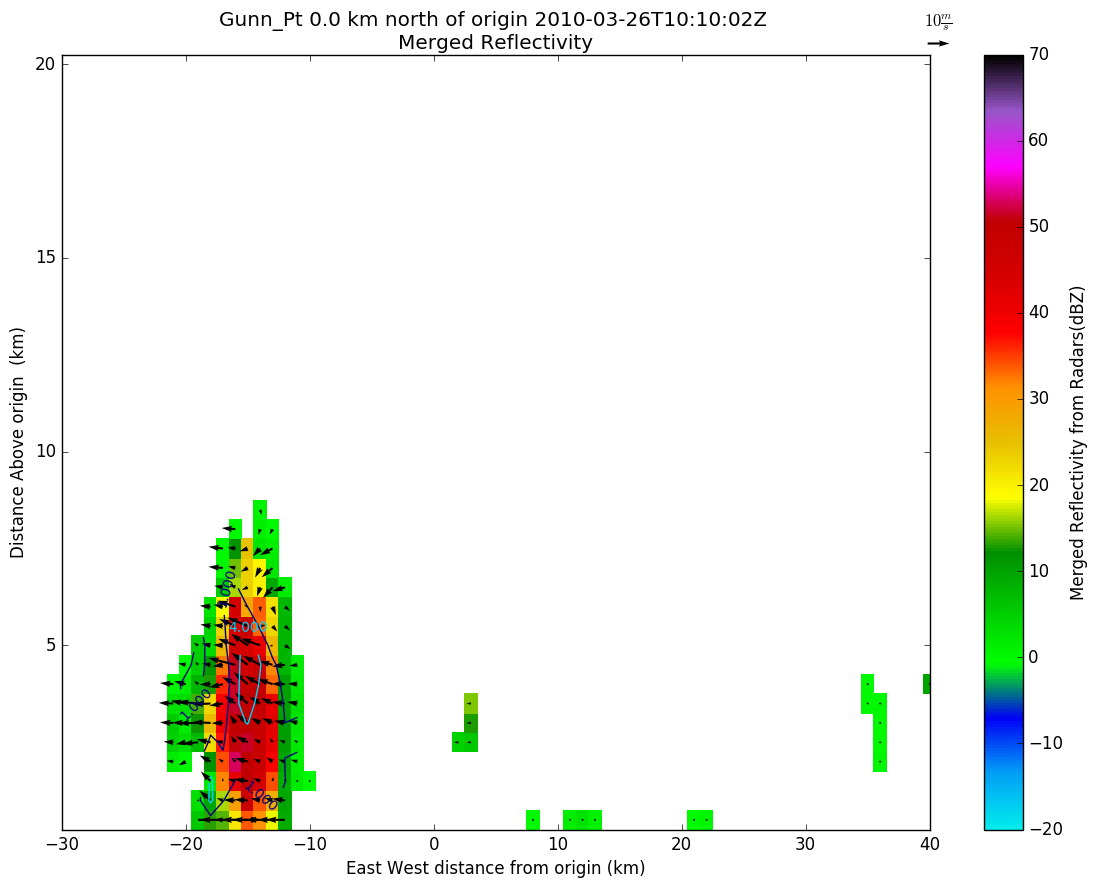

In [93]:
level = 60
fig1 = plt.figure(figsize=(14,10))
CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid)
CPOLGridDisplay.plot_latitudinal_level('reflectivity', level,
                                       cmap=pyart.graph.cm.NWSRef,
                                       vmin=-20, vmax=70)                           

X,Y = np.meshgrid(pyart_grid.x['data']/1e3, pyart_grid.z['data']/1e3)
v = pyart_grid.fields['upward_air_velocity']['data'][:,level,:]
u = pyart_grid.fields['eastward_wind']['data'][:,level,:]
q = plt.quiver(X, Y, u, v, scale=400)
qk = plt.quiverkey(q, 1.01, 1.015, 10, r'$10  \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
CS = plt.contour(X,Y, v, levels=[1,4,6,10])
plt.clabel(CS, inline=1, fontsize=10)
plt.xlim([-30, 40])